# siim COVID-19 X-Ray competition in a "traditional" way of using Keras Layers (JPG)

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import pathlib
from PIL import Image
import ast
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
    
from tensorflow.keras.applications import VGG16

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import pickle
import cv2

In [2]:
%cd /tf/Kostya_working_dir/

/tf/Kostya_working_dir


## Preprocess dataframes

In [3]:
!pwd

train_image = pd.read_csv('/tf/data/DCM/train_image_level.csv')
train_study = pd.read_csv('/tf/data/DCM/train_study_level.csv')
sample_submission = pd.read_csv('/tf/data/DCM/sample_submission.csv')

/tf/Kostya_working_dir


In [4]:
print(len(train_image))
print(len(train_study))

6334
6054


### NOTES: 
1. *Study* is the name of the folder immediately within the train/test datasets. That name is **id** column in the **train_study.csv**. Within that folder there is/are some other folders (usually just one) and within that last folder there is an image and the name of that image is 'Image' **id** column in the **train_image.csv**. 
2. You have to make predictions for both _study_ and _image_ names and include them (with respective suffixes added) to submission.csv.
    * For _image_ you have to format as **opacity 1 100 200 300 400**
    * For _study_ you have to format as **typical 1 0 0 1 1** (here we change only the first word and save the same numbers for all cases)
    * For negative case you should format _study_ as **negative 1 0 0 1 1**, but _image_ as **none 1 0 0 1 1**.

3. Some of the values in the **StudyInstanceUID** column in **train_image** are related (point) to several images - therefore there are 6334 images but only 6054 StudyInstanceUID's. (Does it mean that multiple images have identical bboxes and labels and this was done just to save time and space for identical boxes/labels?)
4. **StudyInstanceUID** column in **train_image** are identical to the **id** column in **train_study** (but without the _study suffix)

In [7]:
train_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


#### Rename columns and remove extensions

In [5]:
train_study['id'] = train_study['id'].str.replace('_study', '')

train_study.rename(columns={'id': 'StudyInstanceUID'}, inplace=True)

train_result = train_image.merge(train_study, on='StudyInstanceUID', how='left')

train_result['id'] = train_result['id'].str.replace('_image', '')

In [106]:
train_result

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0
...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445,NaN,none 1 0 0 1 1,7e6c68462e06,1,0,0,0
6330,ffd91a2c4ca0,NaN,none 1 0 0 1 1,8332bdaddb6e,1,0,0,0
6331,ffd9b6cf2961,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,0,1,0,0
6332,ffdc682f7680,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0


#### Add original dimensions (for scaling)

In [7]:
original_dims = pd.read_csv('/tf/data/JPEG/meta.csv')

In [8]:
original_dims.head()

,image_id,dim0,dim1,split
0,a29c5a68b07b,2320,2828,test
1,9850b5470fd6,2330,2382,test
2,8d6dea06a032,2422,3344,test
3,dfc5c09a50bc,1140,1387,test
4,7230234e120a,2318,2383,test


In [9]:
original_dims.rename(columns={'image_id': 'id'}, inplace=True)

train_result_final = train_result.merge(original_dims, on='id', how='left')

In [10]:
train_result_final.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,dim0,dim1,split
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,3488,4256,train
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,2320,2832,train
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2544,3056,train
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,3520,4280,train
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2800,3408,train


#### Add extensions to filenames

In [11]:
train_result_final['id'] = train_result_final['id'] + '.jpg'

In [12]:
train_result_final.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,dim0,dim1,split
0,000a312787f2.jpg,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,3488,4256,train
1,000c3a3f293f.jpg,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,2320,2832,train
2,0012ff7358bc.jpg,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2544,3056,train
3,001398f4ff4f.jpg,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,3520,4280,train
4,001bd15d1891.jpg,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2800,3408,train


### Scale bboxes proportionally

In [13]:
train_result_final["boxes"] = train_result_final["boxes"].fillna("[{'x':0, 'y':0, 'width':1, 'height':1}]")

In [14]:
train_result_final["boxes"] = train_result_final["boxes"].apply(lambda x: ast.literal_eval(x))

In [15]:
train_result_final.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,dim0,dim1,split
0,000a312787f2.jpg,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,3488,4256,train
1,000c3a3f293f.jpg,"[{'x': 0, 'y': 0, 'width': 1, 'height': 1}]",none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,2320,2832,train
2,0012ff7358bc.jpg,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2544,3056,train
3,001398f4ff4f.jpg,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,3520,4280,train
4,001bd15d1891.jpg,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2800,3408,train


### Convert and scale bboxes coordinates

In [16]:
def unpack_bboxes(df):
    """ go from xmin,ymin,width,height --> xmin,ymin,xmax,ymax """
    for dictionary in df["boxes"]:
        df["xmin"] = dictionary["x"]
        df["ymin"] = dictionary["y"]
        df["xmax"] = dictionary["x"] + dictionary["width"]
        df["ymax"] = dictionary["y"] + dictionary["height"]
    return df

In [17]:
def scale_bbox_coor(df):
    if df['xmin'] != 0:
        df['xmin'] *= (256 / df['dim1'])
        df['xmax'] *= (256 / df['dim1'])
        df['ymin'] *= (256 / df['dim0'])
        df['ymax'] *= (256 / df['dim0'])
    return df

In [18]:
print("Unpacking bboxes into separate columns. This will take ~20 secs")
train_result_final = train_result_final.apply(unpack_bboxes, axis=1)

Unpacking bboxes into separate columns. This will take ~20 secs


In [19]:
train_result_final = train_result_final.apply(scale_bbox_coor, axis=1)

In [20]:
train_result_final.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,dim0,dim1,split,xmin,ymin,xmax,ymax
0,000a312787f2.jpg,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,3488,4256,train,135.092456,43.391213,200.936764,172.679246
1,000c3a3f293f.jpg,"[{'x': 0, 'y': 0, 'width': 1, 'height': 1}]",none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,2320,2832,train,0.000000,0.000000,1.000000,1.000000
2,0012ff7358bc.jpg,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2544,3056,train,150.173038,40.508428,201.861192,161.701686
3,001398f4ff4f.jpg,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,3520,4280,train,163.229907,158.642423,219.932717,202.569695
4,001bd15d1891.jpg,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2800,3408,train,193.695144,91.306667,243.472922,193.706667


### Add classes (str and num)

In [21]:
labels_dict = {'Negative for Pneumonia': ["negative", 0], 'Typical Appearance': ["typical", 1], 'Indeterminate Appearance': ["indeterminate", 2], 'Atypical Appearance': ["atypical", 3]}

In [22]:
def convert_and_combine_classes(df):
    for lbl in labels_dict:
        if df[lbl]:
            df['class'] = labels_dict[lbl][0]
            df['class_num'] = labels_dict[lbl][1]
    return df

In [23]:
train_result_final = train_result_final.apply(convert_and_combine_classes, axis=1)

In [24]:
train_result_final.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,dim0,dim1,split,xmin,ymin,xmax,ymax,class,class_num
0,000a312787f2.jpg,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,3488,4256,train,135.092456,43.391213,200.936764,172.679246,typical,1
1,000c3a3f293f.jpg,"[{'x': 0, 'y': 0, 'width': 1, 'height': 1}]",none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,2320,2832,train,0.000000,0.000000,1.000000,1.000000,negative,0
2,0012ff7358bc.jpg,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2544,3056,train,150.173038,40.508428,201.861192,161.701686,typical,1
3,001398f4ff4f.jpg,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,3520,4280,train,163.229907,158.642423,219.932717,202.569695,atypical,3
4,001bd15d1891.jpg,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2800,3408,train,193.695144,91.306667,243.472922,193.706667,typical,1


In [28]:
train_result_final.to_csv('train_result_final.csv')

In [2]:
# train_result_final = pd.read_csv('train_result_final.csv')

# Split train images into train/validation datasets

In [25]:
!rm -rf /tf/Kostya_working_dir/images
!rm -rf /tf/Kostya_working_dir/annotations

!mkdir -p /tf/Kostya_working_dir/images
!mkdir -p /tf/Kostya_working_dir/annotations

!mkdir -p /tf/Kostya_working_dir/images/negative
!mkdir -p /tf/Kostya_working_dir/images/typical
!mkdir -p /tf/Kostya_working_dir/images/indeterminate
!mkdir -p /tf/Kostya_working_dir/images/atypical

In [26]:
!mkdir -p /tf/Kostya_working_dir/output
!mkdir -p /tf/Kostya_working_dir/output/plots

### Move images to repsective folders (acc. to classes)

In [27]:
type(train_result_final['class'])

pandas.core.series.Series

In [28]:
import shutil

original_dataset_path = '/tf/data/JPEG/entire_dataset/'

def split_dataset_to_classes():
    for _, row in train_result_final.iterrows():
        class_type = row['class']
        source_file_path = os.path.join(original_dataset_path, (row['id']))
        print(source_file_path)
        dest_file_path = os.path.join('/tf/Kostya_working_dir/images', class_type, (row['id']))
        print(dest_file_path)
        shutil.copy(source_file_path, dest_file_path)

In [29]:
split_dataset_to_classes()

/tf/data/JPEG/entire_dataset/000a312787f2.jpg
/tf/Kostya_working_dir/images/typical/000a312787f2.jpg
/tf/data/JPEG/entire_dataset/000c3a3f293f.jpg
/tf/Kostya_working_dir/images/negative/000c3a3f293f.jpg
/tf/data/JPEG/entire_dataset/0012ff7358bc.jpg
/tf/Kostya_working_dir/images/typical/0012ff7358bc.jpg
/tf/data/JPEG/entire_dataset/001398f4ff4f.jpg
/tf/Kostya_working_dir/images/atypical/001398f4ff4f.jpg
/tf/data/JPEG/entire_dataset/001bd15d1891.jpg
/tf/Kostya_working_dir/images/typical/001bd15d1891.jpg
/tf/data/JPEG/entire_dataset/0022227f5adf.jpg
/tf/Kostya_working_dir/images/indeterminate/0022227f5adf.jpg
/tf/data/JPEG/entire_dataset/0023f02ae886.jpg
/tf/Kostya_working_dir/images/negative/0023f02ae886.jpg
/tf/data/JPEG/entire_dataset/002e9b2128d0.jpg
/tf/Kostya_working_dir/images/typical/002e9b2128d0.jpg
/tf/data/JPEG/entire_dataset/00326161e51e.jpg
/tf/Kostya_working_dir/images/typical/00326161e51e.jpg
/tf/data/JPEG/entire_dataset/0044e449aae1.jpg
/tf/Kostya_working_dir/images/typica

In [31]:
print(len(os.listdir('/tf/Kostya_working_dir/images/negative')))
print(len(os.listdir('/tf/Kostya_working_dir/images/typical/')))
print(len(os.listdir('/tf/Kostya_working_dir/images/indeterminate/')))
print(len(os.listdir('/tf/Kostya_working_dir/images/atypical/')))

1736
3007
1108
483


### Create annotations

In [32]:
train_df = train_result_final.filter(['id', 'xmin', 'ymin', 'xmax', 'ymax', 'class'], axis=1)

In [33]:
train_df

,id,xmin,ymin,xmax,ymax,class
0,000a312787f2.jpg,135.092456,43.391213,200.936764,172.679246,typical
1,000c3a3f293f.jpg,0.000000,0.000000,1.000000,1.000000,negative
2,0012ff7358bc.jpg,150.173038,40.508428,201.861192,161.701686,typical
3,001398f4ff4f.jpg,163.229907,158.642423,219.932717,202.569695,atypical
4,001bd15d1891.jpg,193.695144,91.306667,243.472922,193.706667,typical
...,...,...,...,...,...,...
6329,ffcc6edd9445.jpg,0.000000,0.000000,1.000000,1.000000,negative
6330,ffd91a2c4ca0.jpg,0.000000,0.000000,1.000000,1.000000,negative
6331,ffd9b6cf2961.jpg,59.362790,77.408832,92.276873,168.443936,typical
6332,ffdc682f7680.jpg,60.500000,116.306577,100.333331,173.248476,typical


In [34]:
classes_dataframes = {}

for name in train_df['class'].unique():
    classes_dataframes[name] = train_df[train_df['class'] == name]

In [35]:
for k, v in classes_dataframes.items():
    v.to_csv(os.path.join('/tf/Kostya_working_dir/annotations/', f'{k}.csv'))

In [73]:
classes_dataframes.keys()

dict_keys(['typical', 'negative', 'atypical', 'indeterminate'])

# Prepare model

### Paths and configurations

In [37]:
BASE_PATH = "/tf/Kostya_working_dir"
IMAGES_PATH = os.path.join(BASE_PATH, "images")
ANNOTS_PATH = os.path.join(BASE_PATH, "annotations")

BASE_OUTPUT = os.path.join(BASE_PATH, "output")

MODEL_PATH = os.path.join(BASE_OUTPUT, "detector.h5")
LB_PATH = os.path.join(BASE_OUTPUT, "lb.pickle")
PLOTS_PATH = os.path.join(BASE_OUTPUT, "plots")
TEST_PATHS = os.path.join(BASE_OUTPUT, "test_paths.txt")

# Added another model
# EFF_NET_MODEL_PATH = os.path.join(BASE_OUTPUT, "efficient_net.h5")
# EFF_NET_LB_PATH = os.path.join(BASE_OUTPUT, "eff_net_lb.pickle")

In [38]:
TEST_PATHS

'/tf/Kostya_working_dir/output/test_paths.txt'

In [39]:
INITIAL_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 32

### Create lists of data (images pixels in np.arrays), labels (strings), bboxes (tuples), image_paths (strings)

In [41]:
data = []
labels = []
bboxes = []
image_paths = []

# Loop over classes in our dataframes_dictionary and 
# loop over rows in respective dataframes and retrieve info
for class_name in classes_dataframes:
    for ind, row in classes_dataframes[class_name].iterrows():
        filename = row['id']
        xmin = row['xmin']
        ymin = row['ymin']
        xmax = row['xmax']
        ymax = row['ymax']
        label = row['class']
        
        # derive the path to the input image, load the image (in
        # OpenCV format), and grab its dimensions
        image_path = os.path.join(IMAGES_PATH, label, filename)
        image_cv2 = cv2.imread(image_path)
        (h, w) = image_cv2.shape[:2]
        
        # scale the bounding box coordinates relative to the 
        # dimensions of the input image
        start_x = xmin / w
        start_y = ymin / h
        end_x = xmax / w
        end_y = ymax / h
        
        # load the image in Keras and preprocess it
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        image = tf.keras.preprocessing.image.img_to_array(image)
        
        # update our list of data, class labels, bounding boxes, and
        # image paths
        data.append(image)
        labels.append(label)
        bboxes.append((start_x, start_y, end_x, end_y))
        image_paths.append(image_path)

In [42]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
image_paths = np.array(image_paths)

In [43]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [44]:
# only there are only two labels in the dataset, then we need to use
# Keras/TensorFlow's utility function as well
if len(lb.classes_) == 2:
    labels = to_categorical(labels)

In [45]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, image_paths, test_size=0.20, random_state=42)

# unpack the data split
(train_images, test_images) = split[:2]
(train_labels, test_pabels) = split[2:4]
(train_bboxes, test_bboxes) = split[4:6]
(train_paths, test_paths) = split[6:]

In [46]:
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(test_paths))
f.close()

[INFO] saving testing image paths...


In [47]:
trainPaths

array(['/tf/Kostya_working_dir/images/typical/63d91d1f0079.jpg',
       '/tf/Kostya_working_dir/images/typical/de95298084e1.jpg',
       '/tf/Kostya_working_dir/images/indeterminate/26979950fcc9.jpg',
       ...,
       '/tf/Kostya_working_dir/images/indeterminate/0022227f5adf.jpg',
       '/tf/Kostya_working_dir/images/indeterminate/267a250932bc.jpg',
       '/tf/Kostya_working_dir/images/typical/4b89e049fd7b.jpg'],
      dtype='<U60')

## My little model

In [55]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten()
])

In [56]:
flatten = base_model.output

In [57]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bbox_head = Dense(128, activation="relu")(flatten)
bbox_head = Dense(64, activation="relu")(bbox_head)
bbox_head = Dense(32, activation="relu")(bbox_head)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head)

# construct a second fully-connected layer head, this one to predict
# the class label
label_head = Dense(512, activation="relu")(flatten)
label_head = Dropout(0.5)(label_head)
label_head = Dense(512, activation="relu")(label_head)
label_head = Dropout(0.5)(label_head)
label_head = Dense(len(lb.classes_), activation="softmax", name="class_label")(label_head)

# putting it all together (accept an input image and then output
# bounding box coordinates and a class label)
model = Model(inputs=base_model.input, outputs=(bbox_head, label_head))

## Trying pre-trained Xception model

In [41]:
xception_model = tf.keras.applications.Xception(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet")

xception_model.trainable = False

flatten = xception_model.output
flatten = Flatten()(flatten)

83689472/83683744 [==============================] - 1s 0us/step


In [42]:
# Use the same two headers as before

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bbox_head = Dense(128, activation="relu")(flatten)
bbox_head = Dense(64, activation="relu")(bbox_head)
bbox_head = Dense(32, activation="relu")(bbox_head)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head)

# construct a second fully-connected layer head, this one to predict
# the class label
label_head = Dense(512, activation="relu")(flatten)
label_head = Dropout(0.5)(label_head)
label_head = Dense(512, activation="relu")(label_head)
label_head = Dropout(0.5)(label_head)
label_head = Dense(len(lb.classes_), activation="softmax", name="class_label")(label_head)

# putting it all together (accept an input image and then output
# bounding box coordinates and a class label)
model = Model(inputs=xception_model.input, outputs=(bbox_head, label_head))

## Using pre-trained VGG16 model

In [73]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

In [27]:
# Use the same two headers as before

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bbox_head = Dense(128, activation="relu")(flatten)
bbox_head = Dense(64, activation="relu")(bbox_head)
bbox_head = Dense(32, activation="relu")(bbox_head)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head)

# construct a second fully-connected layer head, this one to predict
# the class label
label_head = Dense(512, activation="relu")(flatten)
label_head = Dropout(0.5)(label_head)
label_head = Dense(512, activation="relu")(label_head)
label_head = Dropout(0.5)(label_head)
label_head = Dense(len(lb.classes_), activation="softmax", name="class_label")(label_head)

# putting it all together (accept an input image and then output
# bounding box coordinates and a class label)
model = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))

NameError: name 'vgg' is not defined

In [58]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_3_input (InputLayer)     [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 222, 222, 16) 448         conv2d_3_input[0][0]             
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 111, 111, 16) 0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 109, 109, 32) 4640        max_pooling2d_3[0][0]            
____________________________________________________________________________________________

In [59]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error",}

# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

opt = Adam(learning_rate=INITIAL_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)

In [60]:
# construct a dictionary for our target training outputs
train_targets = {"class_label": train_labels, "bounding_box": train_bboxes}

# construct a second dictionary, this one for our target testing
# outputs
test_targets = {"class_label": test_labels, "bounding_box": test_bboxes}

## Training the model

In [61]:
# train the network for bounding box regression and class label
# prediction

H = model.fit(
    train_images, train_targets,
    validation_data=(test_images, test_targets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1)

[INFO] training model...
Epoch 1/20
159/159 [==============================] - 6s 25ms/step - loss: 1.3939 - bounding_box_loss: 0.1453 - class_label_loss: 1.2486 - bounding_box_accuracy: 0.3736 - class_label_accuracy: 0.4549 - val_loss: 1.2886 - val_bounding_box_loss: 0.1113 - val_class_label_loss: 1.1773 - val_bounding_box_accuracy: 0.6062 - val_class_label_accuracy: 0.4933
Epoch 2/20
159/159 [==============================] - 3s 21ms/step - loss: 1.3308 - bounding_box_loss: 0.1390 - class_label_loss: 1.1918 - bounding_box_accuracy: 0.4654 - class_label_accuracy: 0.5064 - val_loss: 1.2487 - val_bounding_box_loss: 0.1071 - val_class_label_loss: 1.1415 - val_bounding_box_accuracy: 0.4286 - val_class_label_accuracy: 0.5485
Epoch 3/20
159/159 [==============================] - 3s 21ms/step - loss: 1.2858 - bounding_box_loss: 0.1341 - class_label_loss: 1.1517 - bounding_box_accuracy: 0.4975 - class_label_accuracy: 0.5433 - val_loss: 1.2332 - val_bounding_box_loss: 0.1062 - val_class_label_

### [OPTIONAL] Save the model on disk

In [47]:
# save the model
model.save(MODEL_PATH, save_format="h5")

# save the label
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving object detector model...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


[INFO] saving label binarizer...


## Plot the losses

In [85]:
# plot the total loss, label loss, and bounding box loss
loss_names = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(loss_names):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()

# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plot_path = os.path.sep.join([PLOTS_PATH, "losses.png"])
plt.savefig(plot_path)
plt.close()

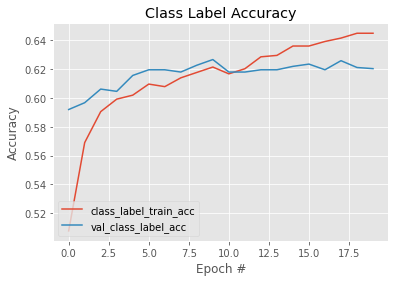

In [86]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"], label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"], label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# save the accuracies plot
plot_path = os.path.sep.join([PLOTS_PATH, "accs.png"])
plt.savefig(plot_path)

## [OPTIONAL] Load the model

In [4]:
# load our object detector and label binarizer from disk
print("[INFO] loading object detector...")
model = tf.keras.models.load_model(MODEL_PATH)
lb = pickle.loads(open(LB_PATH, "rb").read())

[INFO] loading object detector...


## Evaluate the model on the test set

In [125]:
test_images_path = '/tf/data/JPEG/test'

# loop over the images that we'll be testing using our bounding box
# regression model

filenames = os.listdir(test_images_path)

In [126]:
predictions = {}
bboxes = []
classes_labels = []

for filename in sorted(filenames):
    image_path = os.path.join(test_images_path, filename)
    
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image_original = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    image = np.expand_dims(image_original, axis=0)
    
    # predict the bounding box of the object along with the class
    # label
    (box_preds, label_preds) = model.predict(image)
    (start_x, start_y, end_x, end_y) = box_preds[0]
    
    # determine the class label with the largest predicted
    # probability
    i = np.argmax(label_preds, axis=1)
    label = lb.classes_[i][0]
    
    # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image_cv2 = cv2.imread(image_path)
    # image_cv2 = imutils.resize(image_cv2, width=256)
    (h, w) = image_cv2.shape[:2]
    
    # scale the predicted bounding box coordinates based on the image
    # dimensions
       
    start_x = int(start_x * w)
    start_y = int(start_y * h)
    end_x = int(end_x * w)
    end_y = int(end_y * h)
    
    bboxes.append([start_x, start_y, end_x, end_y])
    classes_labels.append(label)

In [67]:
filenames

['37c6c0aee54b.jpg',
 '91558723b2cd.jpg',
 'e49489fcf5c0.jpg',
 'f1b66ff8f4eb.jpg',
 '16972e92e827.jpg',
 'f90deb13b3e2.jpg',
 'c5c3fab94f6f.jpg',
 '4fff9ae1ff37.jpg',
 '11f8052288c7.jpg',
 '1ade3b5d0699.jpg',
 '53b4af5b74d7.jpg',
 '9f526498d12b.jpg',
 'a489286e78c1.jpg',
 '699fc1ec26f9.jpg',
 'd997c6c6a9b4.jpg',
 '896d667947af.jpg',
 'a88f38a36bb2.jpg',
 '720a67515500.jpg',
 'fec0249d70e4.jpg',
 '9e78e0ae2f3e.jpg',
 '49fb3141efe3.jpg',
 '9310ceec556a.jpg',
 'c3d79bd7e833.jpg',
 'dbae9b9b9500.jpg',
 'a72e1270f4cd.jpg',
 '10d3c965a5b4.jpg',
 'cc495995f8f5.jpg',
 '776686ca2f1b.jpg',
 '516d9b3ee48c.jpg',
 '36ba388a18df.jpg',
 'c010822b2938.jpg',
 'c47fc2a4baaf.jpg',
 '70bee63a6740.jpg',
 'd5911a060ee4.jpg',
 'beb80bb88a6e.jpg',
 '82af7f7081d7.jpg',
 '13c550e44b7c.jpg',
 '0c2ad4c7a6c4.jpg',
 '4eecfe2a4de1.jpg',
 '07db3756ec28.jpg',
 '2533fc9ec975.jpg',
 '1d674718db40.jpg',
 'd750be1736db.jpg',
 'ee27ca277911.jpg',
 'c3d0378f8856.jpg',
 'd1912847d707.jpg',
 '51a0100c5921.jpg',
 '32b211904f5

In [74]:
classes_labels

['negative',
 'typical',
 'negative',
 'negative',
 'negative',
 'negative',
 'typical',
 'negative',
 'negative',
 'negative',
 'typical',
 'typical',
 'negative',
 'typical',
 'typical',
 'typical',
 'typical',
 'typical',
 'typical',
 'typical',
 'typical',
 'typical',
 'indeterminate',
 'typical',
 'negative',
 'negative',
 'typical',
 'typical',
 'negative',
 'typical',
 'negative',
 'negative',
 'negative',
 'negative',
 'typical',
 'typical',
 'typical',
 'typical',
 'typical',
 'typical',
 'typical',
 'indeterminate',
 'negative',
 'typical',
 'typical',
 'typical',
 'typical',
 'negative',
 'typical',
 'negative',
 'typical',
 'negative',
 'negative',
 'typical',
 'typical',
 'typical',
 'typical',
 'negative',
 'typical',
 'negative',
 'typical',
 'typical',
 'typical',
 'indeterminate',
 'typical',
 'typical',
 'negative',
 'negative',
 'typical',
 'typical',
 'indeterminate',
 'typical',
 'typical',
 'typical',
 'typical',
 'typical',
 'typical',
 'typical',
 'indeterminate

In [64]:
bboxes

[[74, 67, 98, 115],
 [108, 43, 153, 117],
 [35, 23, 28, 24],
 [12, 15, 13, 15],
 [27, 29, 35, 36],
 [42, 27, 38, 34],
 [115, 89, 176, 198],
 [97, 106, 135, 158],
 [43, 47, 67, 66],
 [19, 21, 21, 29],
 [119, 50, 171, 153],
 [110, 94, 185, 215],
 [24, 50, 50, 76],
 [72, 86, 111, 138],
 [143, 110, 190, 176],
 [101, 135, 164, 197],
 [116, 81, 181, 171],
 [124, 74, 163, 135],
 [109, 85, 151, 165],
 [128, 30, 196, 146],
 [134, 84, 186, 171],
 [5, 14, 18, 48],
 [194, 125, 233, 220],
 [131, 80, 163, 183],
 [17, 16, 14, 16],
 [38, 28, 74, 48],
 [116, 60, 165, 137],
 [44, 77, 64, 111],
 [86, 54, 111, 88],
 [100, 99, 165, 194],
 [17, 36, 21, 42],
 [46, 12, 32, 18],
 [32, 76, 48, 88],
 [57, 81, 78, 106],
 [84, 107, 155, 181],
 [49, 62, 83, 105],
 [106, 120, 142, 182],
 [104, 121, 175, 176],
 [138, 88, 192, 182],
 [144, 127, 204, 240],
 [143, 64, 194, 157],
 [92, 111, 136, 170],
 [13, 18, 12, 19],
 [124, 119, 161, 176],
 [79, 57, 138, 135],
 [113, 79, 177, 184],
 [26, 100, 65, 187],
 [52, 46, 60, 5

### Draw a few images with predictions

In [94]:
def draw_image_bbox_class(filename):
    
    image_path = os.path.join(test_images_path, filename)
    
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    
    # predict the bounding box of the object along with the class
    # label
    (box_preds, label_preds) = model.predict(image)
    (start_x, start_y, end_x, end_y) = box_preds[0]
    
    # determine the class label with the largest predicted
    # probability
    i = np.argmax(label_preds, axis=1)
    label = lb.classes_[i][0]
    
    # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image_cv2 = cv2.imread(image_path)
    # image = imutils.resize(image, width=256)
    (h, w) = image_cv2.shape[:2]
    
    # scale the predicted bounding box coordinates based on the image
    # dimensions
    x = int(start_x * w)
    y = int(start_y * h)
    end_x = int(end_x * w)
    end_y = int(end_y * h)
    
    width = end_x - x
    height = end_y - y
    
    # Create figure and axes
    fig, ax = plt.subplots(1,1, figsize=(7,7))

    # Display the image
    ax.imshow(image)

    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.text(x,(y-15),str(label),verticalalignment='top', color='white',fontsize=15,weight='bold')
    
    plt.show()
    

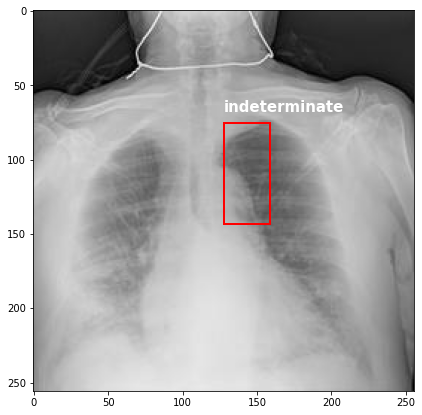

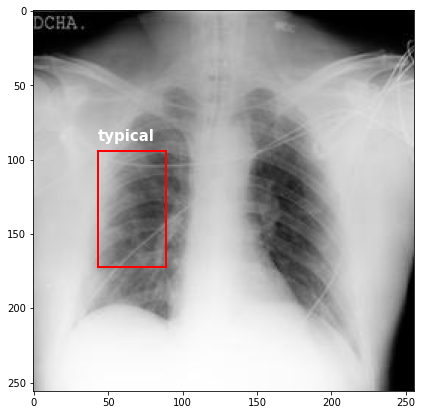

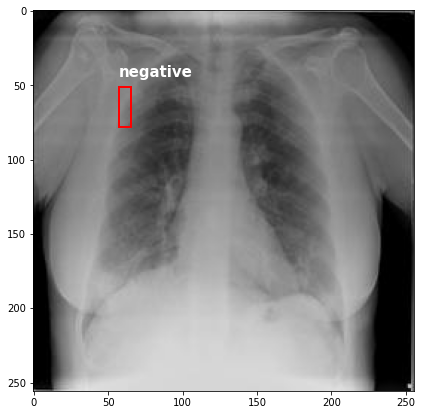

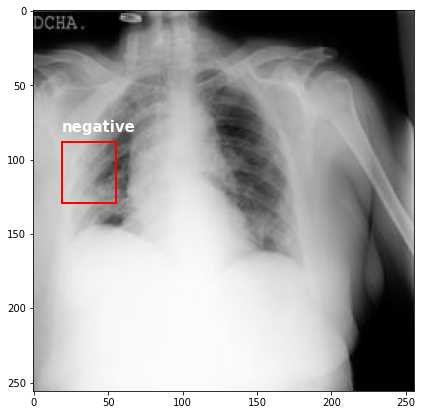

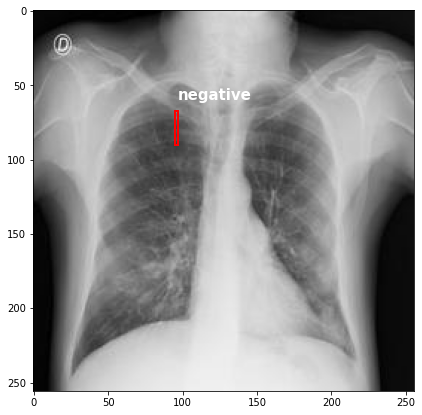

In [97]:
import random

filenames = random.sample(os.listdir(test_images_path), 5)

for filename in filenames:
    draw_image_bbox_class(filename)

# Create predictions dataframes

In [127]:
submission_images = pd.DataFrame({'id': sorted(filenames), 'class': classes_labels, 'bboxes': bboxes})

In [9]:
submission_images = pd.read_csv('submission_sorted_filenames.csv')

In [11]:
submission_images

,id,PredictionString
0,0026720152f5,none 1 0 0 1 1
1,00fc8fc35dc1,typical 1 145 72 203 151
2,01c3512eebc3,none 1 0 0 1 1
3,01f948f8e544,none 1 0 0 1 1
4,022146012034,none 1 0 0 1 1
...,...,...
1258,fed3a460884c,atypical 1 41 62 56 98
1259,ff5448be90d5,none 1 0 0 1 1
1260,ff88ed1df29b,indeterminate 1 159 82 203 165
1261,ffb8115a304c,none 1 0 0 1 1


#### This is the old code and it was working. Don't touch. I commented it out.

In [132]:
# submission_images['PredictionString'] = ''

# for ind, row in submission_images.iterrows():
#     row['id'] = row['id'].replace('.jpg', '')
#     if row['class'] != 'negative':
#         pred_list = []
#         pred_list.append(row['class'])
#         pred_list.append('1')
#         for box in row['bboxes']:
#             #print(box)
#             pred_list.append(str(box))
#             #print(pred_list)
#             pred_string = ' '.join(pred_list)
#             #print(pred_string)
#     else:
#         pred_string = 'none 1 0 0 1 1'
#     row['PredictionString'] = pred_string

In [134]:
submission_images['PredictionString'] = ''

for ind, row in submission_images.iterrows():
    row['id'] = row['id'].replace('.jpg', '_image')
    if row['class'] != 'negative':
        pred_list = []
        pred_list.append('opacity')
        pred_list.append('1')
        for box in row['bboxes']:
            #print(box)
            pred_list.append(str(box))
            #print(pred_list)
            pred_string = ' '.join(pred_list)
            #print(pred_string)
    else:
        pred_string = 'none 1 0 0 1 1'
    row['PredictionString'] = pred_string

In [4]:
submission_images

NameError: name 'submission_images' is not defined

You have to make predictions for both study and image names and include them (with respective suffixes added) to submission.csv.

    For image you have to format as opacity 1 100 200 300 400
    For study you have to format as typical 1 0 0 1 1 (here we change only the first word and save the same numbers for all cases)
    For negative case you should format study as negative 1 0 0 1 1, but image as none 1 0 0 1 1.

In [136]:
# submission_study = # TODO! CREATE A DATAFRAME

In [98]:
submission = submission.drop(columns=['class', 'bboxes'])

In [99]:
submission.to_csv('submission.csv', index=False)

In [113]:
!pwd
!tar -zcvf output.tar.gz output
#!tar czf output.tar.gz --directory=output

/tf/Kostya_working_dir
output/
output/test_paths.txt
output/plots/
output/plots/accs.png
output/plots/losses.png
output/detector.h5
output/eff_net_lb.pickle
output/efficient_net.h5
output/lb.pickle


In [98]:
sample_submission

,id,PredictionString
0,00188a671292_study,negative 1 0 0 1 1
1,004bd59708be_study,negative 1 0 0 1 1
2,00508faccd39_study,negative 1 0 0 1 1
3,006486aa80b2_study,negative 1 0 0 1 1
4,00655178fdfc_study,negative 1 0 0 1 1
...,...,...
2472,46719b856de1_image,none 1 0 0 1 1
2473,31c07523a69a_image,none 1 0 0 1 1
2474,f77d7d1aebab_image,none 1 0 0 1 1
2475,ccc5b63ca96d_image,none 1 0 0 1 1


# Appendix

## Create a np array with all imajes

In [1]:
# dataset = np.ndarray(shape=(len(train_image), 1, 256, 256), dtype=np.float32)

# for dirname, _, filenames in os.walk('../input/siim-covid19-resized-to-256px-jpg/train'):
#     i = 0
#     for filename in filenames:
#         path = os.path.join(dirname, filename)
#         img= Image.open(path)  
#         np_arr_image = np.array(img)
#         dataset[i] = np_arr_image
#         i += 1
        
#         if i % 500 == 0:
#             print(f"{i} images added to dataset")
#     print("All images added to dataset!")